In [49]:
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import models
from torch.utils.data import Dataset

class ASLDataset(Dataset):
    def __init__(self, csv_file, is_train=True):
        df = pd.read_csv(csv_file)
        self.is_train = is_train
        self.labels = df.values[:, 0]
        self.data = df.values[:, 1:].reshape(-1, 28, 28).astype('float32')
        self.transform = transforms.Compose([
            transforms.ToTensor() , # Convert the image to a tensor with pixels in the range [0, 1]
            transforms.Normalize(mean=[0, 0, 0], std=[255, 255, 255]),  # Normalize the image with mean and standard deviation
        ])
        self.aug = transforms.Compose([
            transforms.RandomRotation(10),  # Rotate the image randomly by 10 degrees
            transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1)),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.stack((self.data[idx],) * 3, axis=-1)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.is_train:
            image = self.aug(image)
        return image, label

class ASLModel(nn.Module):
    def __init__(self, num_class, device):
        super(ASLModel, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Linear(512, num_class)
        self.model = self.model.to(device)

    def forward(self, x):
        x = self.model(x)
        return x

In [50]:
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch, device):
    model.train()
    train_loss = 0.0
    print(f'[Training Epoch: {epoch+1}]')
    for input, target in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        output = model(input.to(device))
        loss = loss_function(output.to(device), target.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

def eval_one_epoch(model, dataloader, loss_function, epoch, device, is_train=True):
    model.eval()
    correct = 0
    test_loss = 0.0
    with torch.no_grad():
        for input, target in dataloader:
            output = model(input.to(device))
            
            # Calculate the loss
            loss = loss_function(output.to(device), target.to(device))
            test_loss += loss.item()

            # Calculate the accuracy
            predicted = torch.softmax(output,dim=1) 
            _, predicted = torch.max(predicted, 1) 
            predicted = predicted.data.cpu() 
            correct += target.eq(predicted).sum().item()
    test_acc = correct / len(dataloader.dataset)
    test_loss /= len(dataloader)
    set_name = 'Train' if is_train else 'Test'
    print(f'[{set_name} set] Epoch: {epoch + 1}, Accuracy: {100 * test_acc :.2f}% Loss: {loss}')
    return test_acc

In [51]:
device = "cuda" 
train_dataset = ASLDataset("./data/sign_mnist_train.csv")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = ASLDataset("./data/sign_mnist_test.csv", is_train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
model = ASLModel(num_class = 26, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss().to(device)

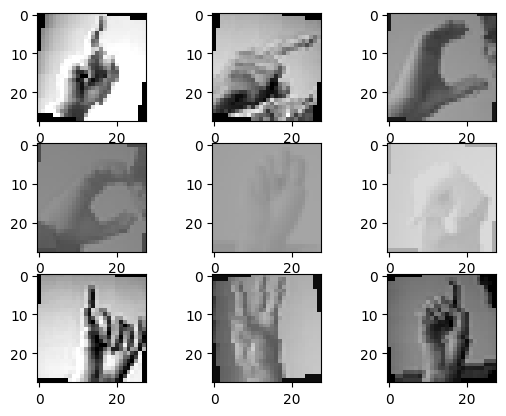

In [52]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = train_dataset[i][0].permute(1, 2, 0)
    plt.imshow(image)

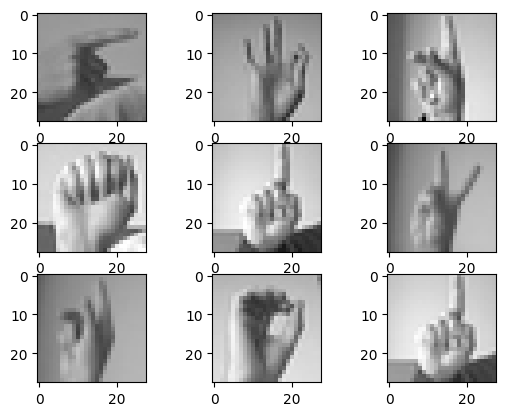

In [53]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    image = test_dataset[i][0].permute(1, 2, 0)
    plt.imshow(image)

In [54]:
for epoch in range(10):
    train_one_epoch(model, train_dataloader, optimizer, loss_function, epoch, device)
    eval_one_epoch(model, train_dataloader, loss_function, epoch, device, is_train=True)
    eval_one_epoch(model, test_dataloader, loss_function, epoch, device, is_train=False)
    print("\n\n")

[Training Epoch: 1]


100%|██████████| 215/215 [00:28<00:00,  7.46it/s]


[Train set] Epoch: 1, Accuracy: 79.96% Loss: 0.6596611738204956
[Test set] Epoch: 1, Accuracy: 86.98% Loss: 0.1569841355085373



[Training Epoch: 2]


100%|██████████| 215/215 [00:28<00:00,  7.46it/s]


[Train set] Epoch: 2, Accuracy: 87.82% Loss: 0.4657462537288666
[Test set] Epoch: 2, Accuracy: 89.88% Loss: 0.00017057356308214366



[Training Epoch: 3]


100%|██████████| 215/215 [00:28<00:00,  7.47it/s]


[Train set] Epoch: 3, Accuracy: 93.33% Loss: 0.22887015342712402
[Test set] Epoch: 3, Accuracy: 93.63% Loss: 2.3304888600250706e-05



[Training Epoch: 4]


100%|██████████| 215/215 [00:28<00:00,  7.47it/s]


[Train set] Epoch: 4, Accuracy: 94.74% Loss: 0.20687180757522583
[Test set] Epoch: 4, Accuracy: 95.09% Loss: 5.006762876291759e-06



[Training Epoch: 5]


100%|██████████| 215/215 [00:28<00:00,  7.48it/s]


[Train set] Epoch: 5, Accuracy: 96.04% Loss: 0.16451777517795563
[Test set] Epoch: 5, Accuracy: 93.70% Loss: 4.8395733756478876e-05



[Training Epoch: 6]


100%|██████████| 215/215 [00:28<00:00,  7.46it/s]


[Train set] Epoch: 6, Accuracy: 96.66% Loss: 0.03419194370508194
[Test set] Epoch: 6, Accuracy: 94.79% Loss: 2.533185806896654e-06



[Training Epoch: 7]


100%|██████████| 215/215 [00:28<00:00,  7.45it/s]


[Train set] Epoch: 7, Accuracy: 97.59% Loss: 0.0934019684791565
[Test set] Epoch: 7, Accuracy: 94.90% Loss: 5.1557558435888495e-06



[Training Epoch: 8]


100%|██████████| 215/215 [00:28<00:00,  7.48it/s]


[Train set] Epoch: 8, Accuracy: 97.83% Loss: 0.08501475304365158
[Test set] Epoch: 8, Accuracy: 96.70% Loss: 1.2516833521658555e-05



[Training Epoch: 9]


100%|██████████| 215/215 [00:28<00:00,  7.48it/s]


[Train set] Epoch: 9, Accuracy: 95.27% Loss: 0.052938517183065414
[Test set] Epoch: 9, Accuracy: 95.22% Loss: 5.9508238337002695e-05



[Training Epoch: 10]


100%|██████████| 215/215 [00:28<00:00,  7.47it/s]


[Train set] Epoch: 10, Accuracy: 96.60% Loss: 0.21586713194847107
[Test set] Epoch: 10, Accuracy: 96.54% Loss: 9.95383015833795e-06





In [ ]:
# name the model and save the weights
name = 'model_1'
torch.save(model.state_dict(), f'./assets/{name}.pt')